<a href="https://colab.research.google.com/github/dath1s/color_imgs_test/blob/main/BW_images_to_RGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Обучение модели / Training colorization model**
Сслыка на обученые модели и на блокнот: https://drive.google.com/drive/folders/1Lme-52j_zx5KLcrQKdAwM7kG6-E9PGac?usp=sharing

## Импорт библиотек/ import packages

In [ ]:
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.io import imsave
from skimage.transform import resize
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

## Импорт VGG16 и создание новой модели на её основе/ Importing VGG16 and creating a new model based on it

**VGG16** - convolutional network for image feature extraction. The project will use some part of the model responsible for feature extraction (encoder).

**VGG16** — сверточная сеть для выделения признаков изображений. В проекте будет использоваться некоторая часть модели, отвечающую за выделение признаков(кодировщик).

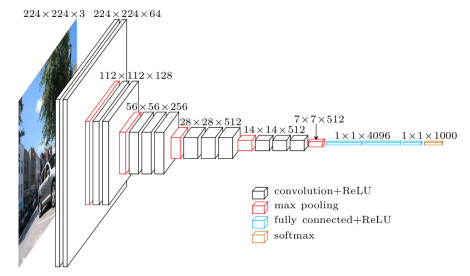

The project will use the first **18 layers** responsible for image convolution.

В проекте будут использоваться первые **18 слоёв**, отвечающие за свертку изображения.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
vgg_model = VGG16()

new_vgg_base_model = Sequential()

for num, layer in enumerate(vgg_model.layers):
  if num < 19:
    new_vgg_base_model.add(layer)
new_vgg_base_model.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_______________________________________________________


Since **some of the layers** that we transferred from VGG16 **are already trained** and we do not want to find weights for these layers, disable the **trainable** parameter, which is responsible for training

Так как **часть слоёв**, которые мы перенесли из VGG16 **уже обучены** и мы не хотим находить веса для данных слоев, отключим параметр **trainable**, отвечающий за обучение

In [ ]:
for layer in new_vgg_base_model.layers:
  layer.trainable=False

## Загрузка файлов для обучения/ Uploading train data

###Подключение Google Диска/ Connecting Google Drive

In [ ]:
from google.colab import drive
# Dataset: https://www.kaggle.com/dath1s/colorize
drive.mount('/content/drive')

Mounted at /content/drive


###Загрузка и проверка файлов/Upload and check files

In [ ]:
"""
 path to train images
 путь до тренировочных изображений
 
 The directory contains ~ 1200 color images 256 by 256 pixels
 Дериктория содержит ~1200 цветных изображений 256 на 256 пикселей
"""

path = '/content/drive/MyDrive/dt'

In [ ]:
"""
    Printing number of files in derictories
    Вывод количества файлов содержащихся в директории
"""
import os
train_dir_len = len(os.listdir(path + '/data'))
print("Length:\t", train_dir_len)

Length:	 1200


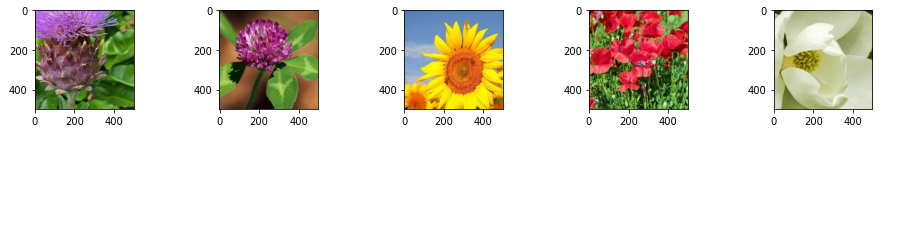

In [ ]:
# Вывод некоторых изображений/ Output some images
pictures = os.listdir(path + '/data')[0:5]

out_pic_box = plt.figure(figsize=(16, 4))
plt.axis('off')

for num, picture in enumerate(pictures):
  pic = Image.open(path + '/data/' + picture)
  pic = pic.resize((500, 500))

  out_pic_box.add_subplot(2, 5, num + 1)
  
  plt.imshow(pic)

plt.show()

## Нормализируем данных для упрощения обучения Нейронной сети / Normalize data to simplification of AI's work 

In [ ]:
"""
 Because colors are represented by a number from 0 to 255, divide the color of each channel
 of all pixels by 255 to represent the color as a number from 0 to 1
 
 Т.к. цвета представляются числом от 0 до 255, поделим цвет каждого канала
 всех пикселей на 255 для представления цвета в виде числа от 0 до 1
"""

train_data_generator = ImageDataGenerator(rescale=1. / 255)

train = train_data_generator.flow_from_directory(directory=path,
                                                target_size=(256, 256),
                                                 batch_size=1200,
                                                 class_mode=None
                                                )

Found 1200 images belonging to 1 classes.


## Подготовим данные для тренировки / Prepare data for training

   To create **training and validation data**, let's translate the image from **RBG** to **Lab** format, since if to predict color from a black and white image for RGB format will need to predict 3 channels. If we try to predict the color for a black and white image for the Lab format, we only have to predict 2 channels.
   **How the Lab image works:** L - luma layer (image in gradation format gray), a and b - color channels.
   For training, we decompose the transformed Lab image into layers L, a and b.
   Channel L will be responsible for **X (input)**, and channel **Y (output) will be answer a and b**

   Для создания **тренировочных и валидационных данных** переведем изображение из **RBG** в формат **Lab**, т.к. если для предсказания цвета по черно-белому изображению для формата RGB надо будет предсказать 3 канала. Если же мы попробуем предсказать цвет  для черно-белого изображения для формата Lab нам придется предсказать только 2 канала.
   **Как устроено Lab изображение:** L - яркостный слой(изображение в формате градации серого), a и b - цветовые каналы.
   Для обучения мы разложем преобразованное изображение Lab на слои L, a и b.
   За **X(входные данные)** будет отвечать канал L, а за **Y(выходные данные) будет отвечать a и b**

In [ ]:
# Массивы для входных и выходных данных
# Massives for input and output data
X = []
Y = []
for img in train[0]:
    try:
        # Изменяем размеризображения, т.к. нейронная сеть на вход принимает тензор 224 на 224
        # Change the size of the image, because the neural network accepts tensor 224 by 224 as input
        resized_image = resize(img, (224, 224))
        lab = rgb2lab(resized_image)
        X.append(lab[:, :, 0])
        Y.append(lab[:, :, 1:] / 128)
        # a и b(цветовые слои) представляются в виде числа от -127 до 128
        # поэтому, для упрощения работы нейронной сети мы нормализируем 
        # данные поделив на 128 и представим их в виде числа от -1 до 1  
        
        # a and b (color layers) are represented as numbers from -127 to 128
        # therefore, to simplify the work of the neural network, we normalize
        # dividing the data by 128 and present it as a number from -1 to 1
    except:
        print('Somthing is wrong')
        
X = np.array(X)
Y = np.array(Y)

# Для работы нейронной сети риведем X и Y к одинаковой форме тензоров
# For the neural network to work, let us reduce X and Y to the same form of tensors

X = X.reshape(X.shape + (1,))

In [ ]:
print(X.shape)
print(Y.shape)

(1200, 224, 224, 1)
(1200, 224, 224, 2)


## Создание закодированных данных с помощью VGG16 для обучения/ Generating encoded data with VGG16 for training

Т.к. модель VGG16 **ориентирована на нахождение и выделение признаков**, закодируем имеющиеся изображения с её помощью для того, чтобы **соотнести некие признаки с цветом**

Because the VGG16 model **is focused on finding and highlighting features**, we will encode the existing images with its help in order to **correlate certain features with color**

In [ ]:
vgg_predicted = []

for num, sample in enumerate(X):
  # VGG16 работает с изображениями формата RGB, следовательно нужно перевести имеющиеся изображения в формат RGB
  # VGG16 works with RGB images, therefore you need to convert existing images to RGB format
  sample = gray2rgb(sample)
  sample = sample.reshape((1, 224, 224, 3))
  prediction = new_vgg_base_model.predict(sample)
  prediction = prediction.reshape((7, 7, 512))
  vgg_predicted.append(prediction)
vgg_predicted = np.array(vgg_predicted)

In [ ]:
print(vgg_predicted.shape)

(1200, 7, 7, 512)


### Сохранение кодировщика/ Saving encoder

In [ ]:
new_vgg_base_model.save('/model/colorize_encoder_vgg.h5')

## Создание декодера/ Creating a decoder

In [ ]:
decoder_model = Sequential([
    Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=(7, 7, 512)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(2, (3, 3), activation='tanh', padding='same'),
    UpSampling2D((2, 2))
])

In [ ]:
decoder_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 7, 7, 256)         1179904   
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 128)         295040    
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 56, 56, 32)       

## Компиляция, обучение модели и сохранение/ Compiling, training and saving the model

In [ ]:
decoder_model.compile(optimizer='adam',
                      loss='mse',
                      metrics=['accuracy'])

In [ ]:
history = decoder_model.fit(vgg_predicted, Y,
                  epochs=10,
                  batch_size=128,
                  verbose=1,
                  validation_split=0.25)

Epoch 1/10
8/8 [==============================] - 34s 4s/step - loss: 0.0432 - accuracy: 0.6081 - val_loss: 0.0407 - val_accuracy: 0.6544
Epoch 2/10
8/8 [==============================] - 34s 4s/step - loss: 0.0424 - accuracy: 0.6245 - val_loss: 0.0407 - val_accuracy: 0.6568
Epoch 3/10
8/8 [==============================] - 33s 4s/step - loss: 0.0422 - accuracy: 0.6249 - val_loss: 0.0401 - val_accuracy: 0.6592
Epoch 4/10
8/8 [==============================] - 34s 4s/step - loss: 0.0414 - accuracy: 0.6270 - val_loss: 0.0398 - val_accuracy: 0.6594
Epoch 5/10
8/8 [==============================] - 33s 4s/step - loss: 0.0407 - accuracy: 0.6267 - val_loss: 0.0397 - val_accuracy: 0.6596
Epoch 6/10
8/8 [==============================] - 34s 4s/step - loss: 0.0410 - accuracy: 0.6271 - val_loss: 0.0399 - val_accuracy: 0.6593
Epoch 7/10
8/8 [==============================] - 36s 5s/step - loss: 0.0402 - accuracy: 0.6264 - val_loss: 0.0399 - val_accuracy: 0.6593
Epoch 8/10
8/8 [==================

### Сохранение модели/ Saving model

In [ ]:
decoder_model.save('/model/colorize_autoencoder.h5')

## Анализ потерь и точности на этапах обучения/ Loss and Accuracy Analysis in the Learning Phases

In [ ]:
# Формирование данных для графика на основе переменной History, созданной методо обучения(fit)
# Formation of data for the graph based on the History variable created by the training method (fit)
history_dict = history.history

### Потери/ loss

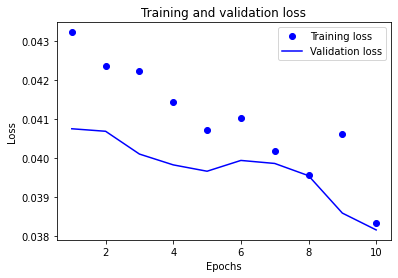

In [ ]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Количество эпох/ Epochs number
epochs = range(1, 11)

# Создание и вывод графика потерь/ Creating and displaying a loss graph
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Точность/ accuracy

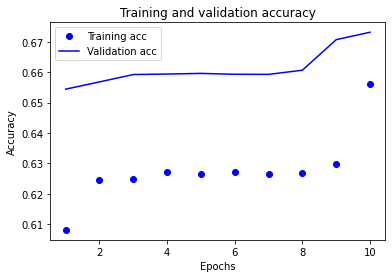

In [ ]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

# Количество эпох/ Epochs number
epochs = range(1, 11)

# Создание и вывод графика точности/ Creating and displaying a accuracy graph
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Тестирование на изображениях/ Testing on images

### Подготовка данных/ Data preparation

In [ ]:
"""
 Для начала загрузите изображение в проект и добавьте путь до изображения в переменную img_path
 First, load the image into the project and add the path to the image to the img_path variable
"""

img_path = '/model/512x512 PNG Landscape Texture - Sunrise Lake.png'
img = Image.open(img_path)

In [ ]:
# Формирование данных/ Forming data
def processed_image(img):
    image = img.resize((224, 224), Image.BILINEAR)
    image = np.array(image, dtype=float)

    lab = rgb2lab(1.0 / 255 * image)
    
    L_lab = lab[:, :, 0]
    L = gray2rgb(L_lab)
    L = L.reshape((1, 224, 224, 3))
    
    vgg_prediction = new_vgg_base_model.predict(L)
    color_channels = decoder_model.predict(vgg_prediction)

    # Т.к. для нормализации данных мы делили цветовые каналы на 128, значит на выходе мы должны цветовые каналы умножить на 128
    # Because to normalize the data, we divided the color channels by 128, which means that at the output we must multiply the color channels by 128
    color_channels *= 128
    
    return color_channels, L_lab


# Формирование изображений/ Forming images
ab, L = processed_image(img)

cur = np.zeros((224, 224, 3))
# Формирование массива Lab изображения/ Forming an array of Lab images
cur[:, :, 0] = L
cur[:, :, 1:] = ab

### Вывoд результата/ output of the result

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 141 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


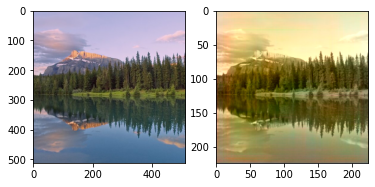

In [ ]:
# Вывод изначального изображения/ Outputting the original image
plt.subplot(1, 2, 1)
plt.imshow(img)

# Вывод изображения предсказанного нейронной сетью/ Outputting an image predicted by a neural network
plt.subplot(1, 2, 2)
plt.imshow(lab2rgb(cur * 1.2))